In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.discrete.discrete_model import Logit 
from scipy import stats
sns.set_style("darkgrid")
plt.rcParams['savefig.dpi'] = 100 
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load data

In [2]:
dates=['delivered_date', 'payment_received_date']
df_mtxn = pd.read_csv(\
'/Volumes/GoogleDrive/My Drive/wish_local/fusion_package_breakdown/store_cannibalization/data/m_transaction_id_mx_1234.csv',\
                parse_dates=dates, infer_datetime_format=True)

/Users/mshi/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_mtxn['geohash_size4'] = df_mtxn['geohash'].apply(lambda x: x[:4] if type(x)==str else x)
df_mtxn['combined'] = df_mtxn['orig_num_fm'].apply(lambda x: 1 if x > 1 else 0)
df_mtxn['combined_2'] = df_mtxn['orig_num_fm'].apply(lambda x: 1 if x > 2 else 0)
df_mtxn['delivered_week'] = df_mtxn['delivered_date'].apply(lambda x: (x - timedelta(days=x.weekday())).date())

In [4]:
df_mtxn = df_mtxn[~((df_mtxn['combined_to'].isna()) |\
          (df_mtxn['orig_user_store_dist'].isna()) | \
          (df_mtxn['orig_user_store_dist']==np.inf))]

In [5]:
df_mtxn.shape, df_mtxn['first_mile_tracking_id'].nunique()

((766080, 35), 677865)

## First mile package level

In [6]:
df = df_mtxn[['first_mile_tracking_id', 'store_id', 'combined_to', \
    'delivered', 'delivered_date', 'user_id', 'orig_num_fm',\
    'last_combined_time', 'orig_user_store_dist', 'geohash', 'store_state', 'geohash_size4', 'combined',
       'combined_2', 'delivered_week', 'logistics_profit_cny']].drop_duplicates()
df.shape

(677865, 16)

In [7]:
df.shape, df['first_mile_tracking_id'].nunique()

((677865, 16), 677865)

# Sample size

In [8]:
# ## Sample size
# During Jan to March, 2021, in MX, there are 318 level 1 (1x1 km)geohashes that had >= 2 active (as of Apr 13) stores receiving orders
# The 998 size 6 geohashes lie in 214 size 4 geohashes
# We want to match lvl 3 geohashes and assign them in control/test groups, 
# We want to make sure the size 6 geohashes in one size 4 geohash are assigned to the same group. 
temp = df[df['store_state']==1].groupby(['geohash'])['store_id'].nunique()
temp = pd.DataFrame(temp[(temp>=2)]).reset_index()
temp['geohash_size4'] = temp['geohash'].apply(lambda x: x[:4])
temp.groupby(['geohash_size4'])['geohash'].nunique().shape, temp['geohash'].nunique()

((214,), 998)

In [ ]:
temp

In [9]:
# There were 229138 first-mile packages during the 3 months in the target geohashes.
# If the test run for 15 days, we will collect data before and after test, 
# so we will have 38k fm packages during the 15 days. 
# If we build a DID model, we will need 15 days +- launch day, and the sample size for modeling will be 76k
geohash_set = set(temp['geohash'].unique())
df[df['geohash'].apply(lambda x: x in geohash_set)]['first_mile_tracking_id'].nunique()

260630

# A/A test

## Stratefied sampling

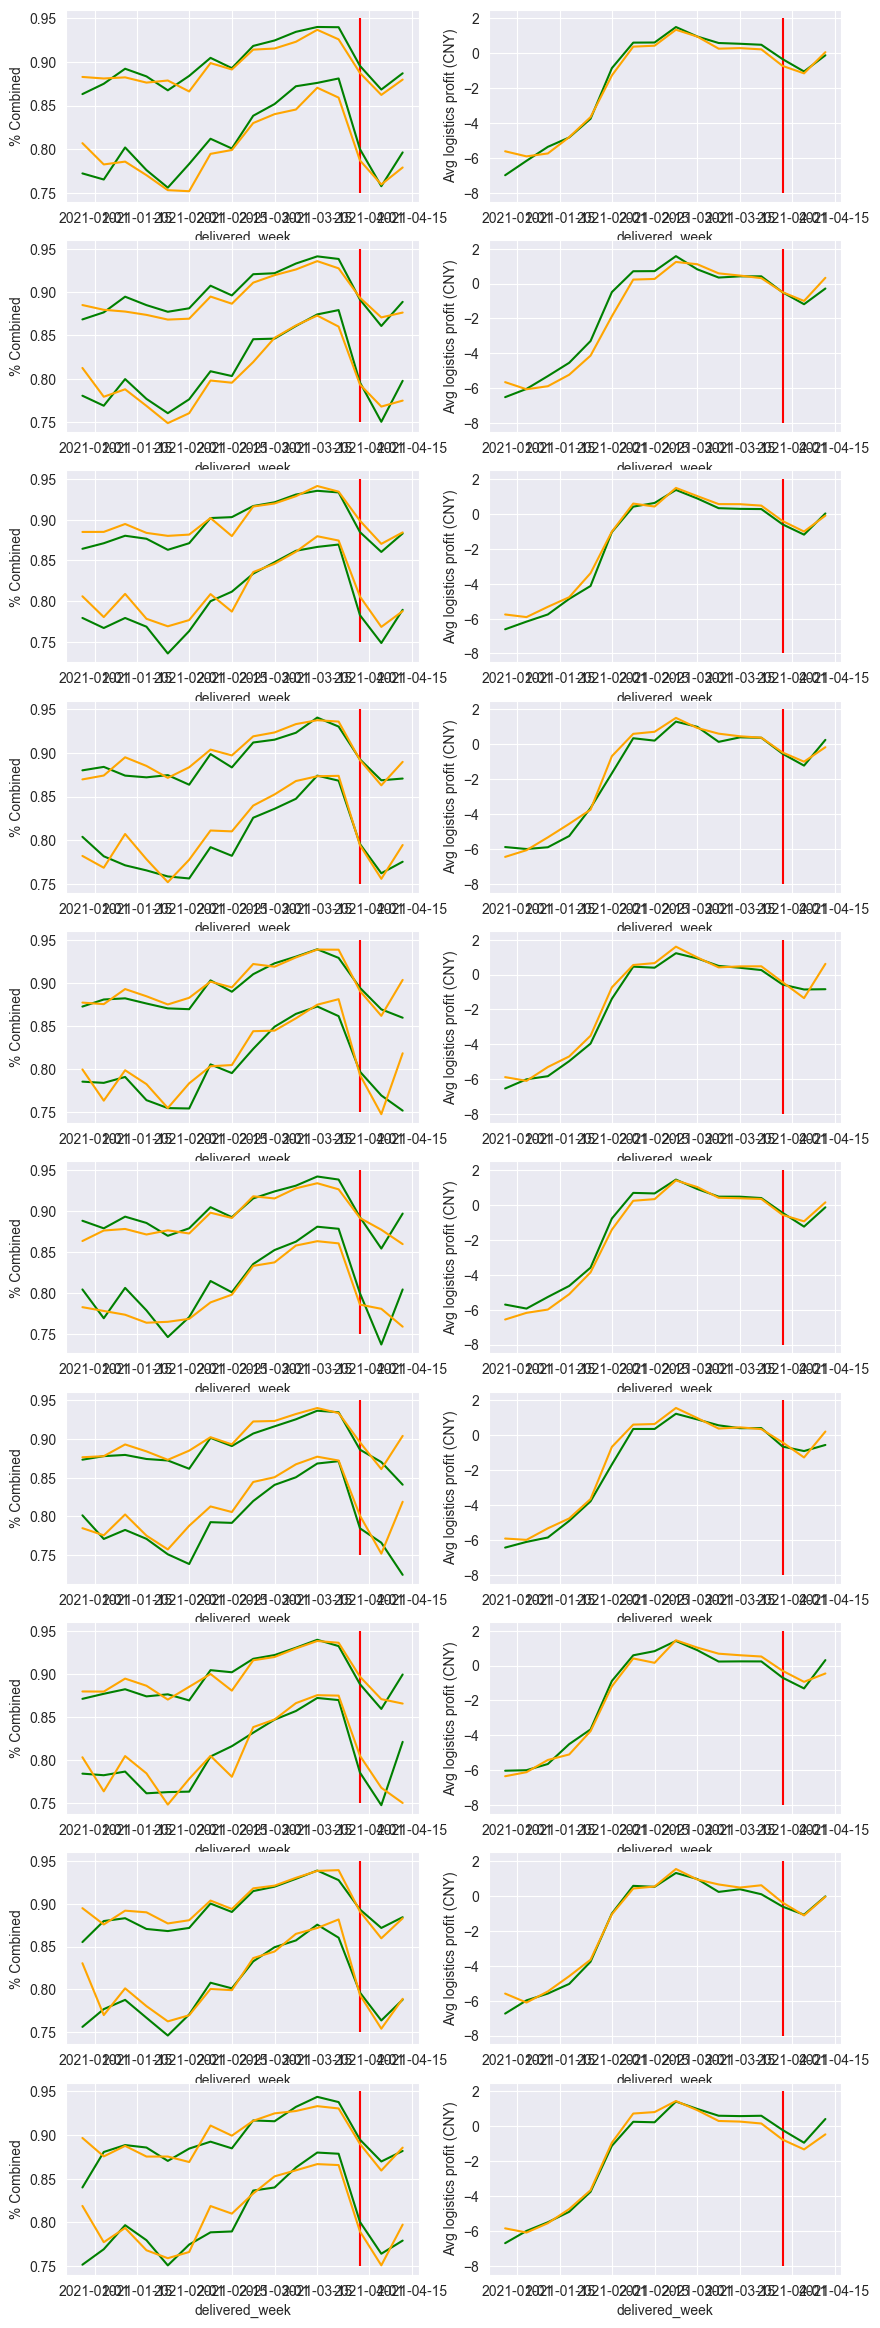

In [12]:
launch_date = datetime(2021,3,29)
fig, axs= plt.subplots(nrows=10, ncols=2, figsize=(10,30))

for i in range(0, 10):
    np.random.seed(i*10)
    
    # data of the geohash for testing 
    df_pool = df[df['geohash'].apply(lambda x: x in geohash_set)].copy(deep=True)


    df_before = df_pool[df_pool['delivered_date']<launch_date].copy(deep=True)
    df_after = df_pool[df_pool['delivered_date']>=launch_date].copy(deep=True)
    df_pivot = pd.pivot_table(df_before,\
                    values=['logistics_profit_cny',
                            'first_mile_tracking_id', \
                            'combined_to',\
                            'user_id', \
                            'geohash', \
                            'store_id', \
                            'combined', \
                            'combined_2'],\
                    index=['geohash_size4'], \
                    aggfunc={'logistics_profit_cny': 'mean',\
                             'first_mile_tracking_id': 'nunique',\
                             'combined_to': 'nunique',\
                             'user_id': 'nunique',\
                             'geohash': 'nunique', \
                             'store_id': 'nunique', \
                             'combined': 'mean', \
                             'combined_2': 'mean'
                            },\
                  )
    df_pivot['combine_rate'] = df_pivot['first_mile_tracking_id'] / df_pivot['combined_to']
    # df_pivot.describe()


    # stratify size 4 geohashes
    df_pivot['num_fm_q3'] = pd.qcut(x=df_pivot['first_mile_tracking_id'], q=3).apply(str)
    df_pivot['combine_rate_q3'] = pd.qcut(x=df_pivot['combine_rate'], q=3).apply(str)
#     df_pivot['store_q3'] = pd.qcut(x=df_pivot['store_id'], q=3).apply(str)
    df_pivot['geohash_q2'] = pd.qcut(x=df_pivot['geohash'], q=2).apply(str)
    df_pivot['profit_q3'] = pd.qcut(x=df_pivot['logistics_profit_cny'], q=3).apply(str)

    df_pivot['stratified_group'] = df_pivot.apply(lambda x: \
                                    ','.join([x['num_fm_q3'], x['combine_rate_q3'], \
                                              x['geohash_q2'], x['profit_q3']]), axis=1)

    # df_pivot.reset_index().groupby(['num_fm_q3', 'combine_rate_q3', 'geohash_q2', 'profit_q3']\
    #                               )['geohash_size4'].agg([set, 'nunique'])

    # sampling
    
    grouped_geohash = df_pivot.reset_index().groupby(['stratified_group'])['geohash_size4'].agg([set, 'nunique'])
    grouped_geohash['test'] = grouped_geohash['set'].apply(\
                                    lambda x: np.random.choice(list(x), \
                                                        size=np.random.choice([len(x)//2, (len(x)+1)//2], replace=False), \
                                                        replace=False))
    grouped_geohash['control'] = grouped_geohash.apply(lambda x: x['set'] - set(x['test']), axis=1)
    # grouped_geohash



    # test group assign
    test_list = grouped_geohash['test'].apply(list).tolist()
    test_set = set([i for sublist in test_list for i in sublist])


    df_pivot = df_pivot.reset_index()
    df_pivot['exp_group'] = df_pivot['geohash_size4'].apply(\
                                    lambda x: 'show' if x in test_set else 'control')
    df_before['exp_group'] = df_before['geohash_size4'].apply(\
                                    lambda x: 'show' if x in test_set else 'control')

    

    # check matching: the metrics of two groups should be close
    df_pool['exp_group'] = df_pool['geohash_size4'].apply(\
                                    lambda x: 'show' if x in test_set else 'control')

    
    # Plot the trend
    df_pool[df_pool['exp_group']=='show'].groupby('delivered_week')['combined'].mean().plot(c='green', ax=axs[i,0])
    df_pool[df_pool['exp_group']=='control'].groupby('delivered_week')['combined'].mean().plot(c='orange', ax=axs[i,0])

    df_pool[df_pool['exp_group']=='show'].groupby('delivered_week')['combined_2'].mean().plot(c='green', ax=axs[i,0])
    df_pool[df_pool['exp_group']=='control'].groupby('delivered_week')['combined_2'].mean().plot(c='orange', ax=axs[i,0])

    axs[i,0].vlines(launch_date, ymin=0.75, ymax=0.95, color='red')
    axs[i,0].set_ylabel('% Combined')
    # axs[0].set_xtick(rotation=45)



    df_pool[df_pool['exp_group']=='show'].groupby('delivered_week')['logistics_profit_cny'].mean().plot(c='green', ax=axs[i,1])
    df_pool[df_pool['exp_group']=='control'].groupby('delivered_week')['logistics_profit_cny'].mean().plot(c='orange', ax=axs[i,1])

    axs[i, 1].vlines(launch_date, ymin=-8, ymax=2, color='red')
    axs[i, 1].set_ylabel('Avg logistics profit (CNY)')

## Random assign

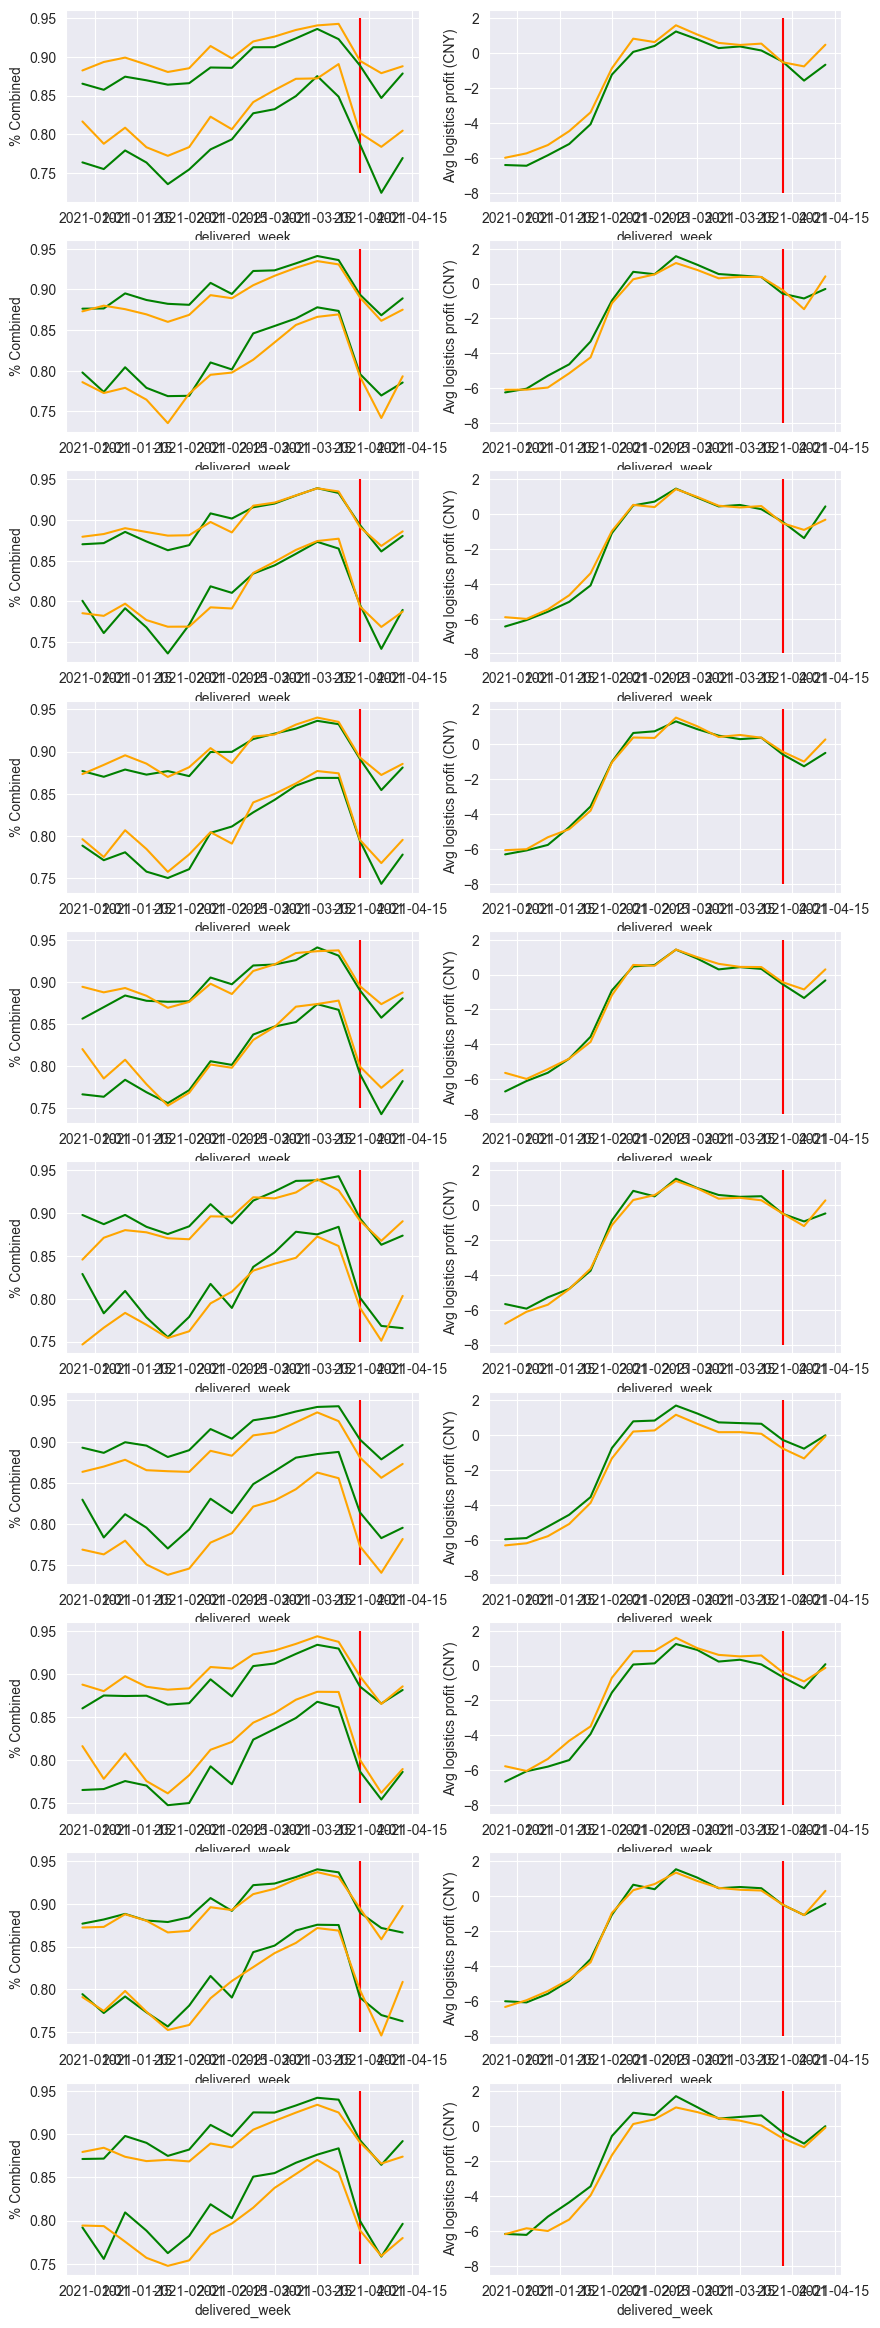

In [13]:
launch_date = datetime(2021,3,29)
fig, axs= plt.subplots(nrows=10, ncols=2, figsize=(10,30))

for i in range(0, 10):
    np.random.seed(i*10)

    # data of the geohash for testing 
    df_pool = df[df['geohash'].apply(lambda x: x in geohash_set)].copy(deep=True)


    df_before = df_pool[df_pool['delivered_date']<launch_date].copy(deep=True)
    df_after = df_pool[df_pool['delivered_date']>=launch_date].copy(deep=True)
    df_pivot = pd.pivot_table(df_before,\
                    values=['logistics_profit_cny',
                            'first_mile_tracking_id', \
                            'combined_to',\
                            'user_id', \
                            'geohash', \
                            'store_id', \
                            'combined', \
                            'combined_2'],\
                    index=['geohash_size4'], \
                    aggfunc={'logistics_profit_cny': 'mean',\
                             'first_mile_tracking_id': 'nunique',\
                             'combined_to': 'nunique',\
                             'user_id': 'nunique',\
                             'geohash': 'nunique', \
                             'store_id': 'nunique', \
                             'combined': 'mean', \
                             'combined_2': 'mean'
                            },\
                  )
    df_pivot['combine_rate'] = df_pivot['first_mile_tracking_id'] / df_pivot['combined_to']
    # df_pivot.describe()

    # test group assign

    df_pivot['random_assign'] = np.nan
    df_pivot['random_assign'] = df_pivot['random_assign'].apply(lambda x: np.random.choice(['show', 'control'], replace=False))


    df_pivot = df_pivot.reset_index()
    df_pool_random = pd.merge(df_pool, df_pivot[['geohash_size4', 'random_assign']], how='left', on='geohash_size4')
    # df_pool_random['random_assign'].head()
    
    # Plot the trend
    df_pool_random[df_pool_random['random_assign']=='show'].groupby(\
                                            'delivered_week')['combined'].mean().plot(c='green', ax=axs[i,0])
    df_pool_random[df_pool_random['random_assign']=='control'].groupby(\
                                            'delivered_week')['combined'].mean().plot(c='orange', ax=axs[i,0])

    df_pool_random[df_pool_random['random_assign']=='show'].groupby(\
                                            'delivered_week')['combined_2'].mean().plot(c='green', ax=axs[i,0])
    df_pool_random[df_pool_random['random_assign']=='control'].groupby(\
                                            'delivered_week')['combined_2'].mean().plot(c='orange', ax=axs[i,0])

    axs[i,0].vlines(launch_date, ymin=0.75, ymax=0.95, color='red')
    axs[i,0].set_ylabel('% Combined')
    # axs[0].set_xtick(rotation=45)



    df_pool_random[df_pool_random['random_assign']=='show'].groupby(\
                                'delivered_week')['logistics_profit_cny'].mean().plot(c='green', ax=axs[i,1])
    df_pool_random[df_pool_random['random_assign']=='control'].groupby(\
                                'delivered_week')['logistics_profit_cny'].mean().plot(c='orange', ax=axs[i,1])

    axs[i, 1].vlines(launch_date, ymin=-8, ymax=2, color='red')
    axs[i, 1].set_ylabel('Avg logistics profit (CNY)')

# All together
## Metrics to assign exp groups:
1. fm package level: combined %, combined_2 %. proportion ztest
2. size 6 geohash level: combined_rate (t-test), # stores per geohash (t-test), # fm packages per geohash (t-test), # users per geohash (t-test). DID interaction term
3. week over week viz as validation for trend: combined%, combined_2%, and logistic profit
4. look at April data for further validation

## Assign groups

random seed = 22
                    combined                                               \
                       count      mean       std  min  25%  50%  75%  max   
after_exp exp_group                                                         
0         control    96598.0  0.903569  0.295182  0.0  1.0  1.0  1.0  1.0   
          show       99031.0  0.903454  0.295339  0.0  1.0  1.0  1.0  1.0   
1         control    32381.0  0.905685  0.292270  0.0  1.0  1.0  1.0  1.0   
          show       32620.0  0.903832  0.294826  0.0  1.0  1.0  1.0  1.0   

                    combined_2                                               
                         count      mean       std  min  25%  50%  75%  max  
after_exp exp_group                                                          
0         control      96598.0  0.816156  0.387359  0.0  1.0  1.0  1.0  1.0  
          show         99031.0  0.814573  0.388645  0.0  1.0  1.0  1.0  1.0  
1         control      32381.0  0.824836  0.380114  0

Text(0, 0.5, 'Avg logistics profit (CNY)')

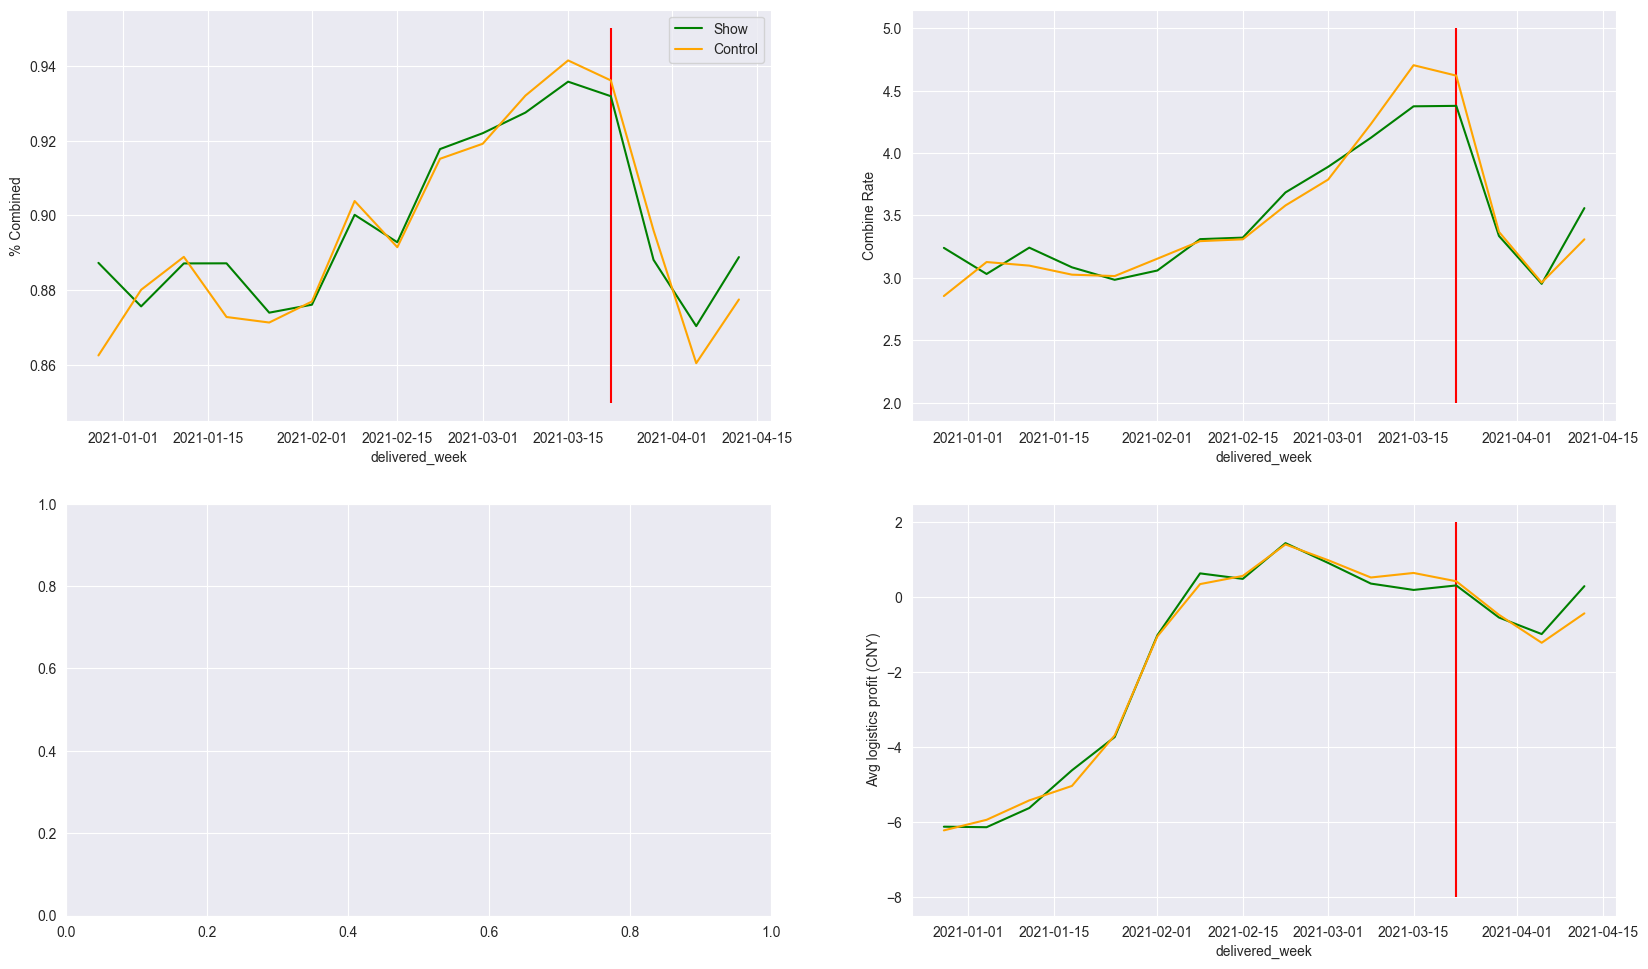

In [205]:
launch_date = datetime(2021,3,22)
i = 22
np.random.seed(i)
print(f'random seed = {i}')
# data of the geohash for testing 
df_pool = df[df['geohash'].apply(lambda x: x in geohash_set)].copy(deep=True)
df_pool['after_exp'] = df_pool['delivered_date'].apply(lambda x: 0 if x<launch_date else 1)

df_before = df_pool[df_pool['delivered_date']<launch_date].copy(deep=True)
df_after = df_pool[df_pool['delivered_date']>=launch_date].copy(deep=True)
df_pivot = pd.pivot_table(df_before,\
                values=['logistics_profit_cny',
                        'first_mile_tracking_id', \
                        'combined_to',\
                        'user_id', \
                        'geohash', \
                        'store_id', \
                        'combined', \
                        'combined_2'],\
                index=['geohash_size4'], \
                aggfunc={'logistics_profit_cny': 'mean',\
                         'first_mile_tracking_id': 'nunique',\
                         'combined_to': 'nunique',\
                         'user_id': 'nunique',\
                         'geohash': 'nunique', \
                         'store_id': 'nunique', \
                         'combined': 'mean', \
                         'combined_2': 'mean'
                        },\
              )
df_pivot['combine_rate'] = df_pivot['first_mile_tracking_id'] / df_pivot['combined_to']
# df_pivot.describe()


# stratify size 4 geohashes
df_pivot['num_fm_q3'] = pd.qcut(x=df_pivot['first_mile_tracking_id'], q=3).apply(str)
df_pivot['combine_rate_q3'] = pd.qcut(x=df_pivot['combine_rate'], q=3).apply(str)
#df_pivot['store_q2'] = pd.qcut(x=df_pivot['store_id'], q=2).apply(str)
df_pivot['geohash_q2'] = pd.qcut(x=df_pivot['geohash'], q=2).apply(str)
df_pivot['profit_q3'] = pd.qcut(x=df_pivot['logistics_profit_cny'], q=3).apply(str)

df_pivot['stratified_group'] = df_pivot.apply(lambda x: \
                                ','.join([x['num_fm_q3'], x['combine_rate_q3'],\
                                          x['geohash_q2'], x['profit_q3']]), axis=1)
,
# df_pivot.reset_index().groupby(['num_fm_q3', 'combine_rate_q3', 'geohash_q2', 'profit_q3']\
#                               )['geohash_size4'].agg([set, 'nunique'])

# sampling

grouped_geohash = df_pivot.reset_index().groupby(['stratified_group'])['geohash_size4'].agg([set, 'nunique'])
grouped_geohash['test'] = grouped_geohash['set'].apply(\
                                lambda x: np.random.choice(list(x), \
                                        size=np.random.choice([len(x)//2, (len(x)+1)//2], replace=False), \
                                         replace=False))
grouped_geohash['control'] = grouped_geohash.apply(lambda x: x['set'] - set(x['test']), axis=1)
# grouped_geohash



# test group assign
test_list = grouped_geohash['test'].apply(list).tolist()
test_set = set([i for sublist in test_list for i in sublist])


df_pivot = df_pivot.reset_index()
df_pivot['exp_group'] = df_pivot['geohash_size4'].apply(\
                                lambda x: 'show' if x in test_set else 'control')
df_before['exp_group'] = df_before['geohash_size4'].apply(\
                                lambda x: 'show' if x in test_set else 'control')



# check matching: the metrics of two groups should be close
df_pool['exp_group'] = df_pool['geohash_size4'].apply(\
                                lambda x: 'show' if x in test_set else 'control')

df_pool['show'] = df_pool['exp_group'].apply(lambda x: 1 if x=='show' else 0)
df_pool['interaction'] = df_pool['show'] * df_pool['after_exp']
df_pool['constant'] = 1

# fm package level: % combined, % combined_2

## before exp
print(df_pool.groupby(['after_exp', 'exp_group'])[['combined', 'combined_2']].describe())
for m in ['combined', 'combined_2']:
    stat, pval = proportions_ztest(count=df_pool[(df_pool['after_exp']==0) & (df_pool[m]==1)].groupby(\
                                    ['exp_group'])['first_mile_tracking_id'].nunique(), \
            nobs=df_pool[(df_pool['after_exp']==0)].groupby(['exp_group'])['first_mile_tracking_id'].nunique())
    

    

    stat2, pval2 = proportions_ztest(count=df_pool[(df_pool['after_exp']==1) & (df_pool[m]==1)].groupby(\
                                        ['exp_group'])['first_mile_tracking_id'].nunique(), \
            nobs=df_pool[(df_pool['after_exp']==1)].groupby(['exp_group'])['first_mile_tracking_id'].nunique())
    
    print(f'Before experiment: {m} %:')
    print(f'stat={stat}, pval={pval}')
    
    print(f'After experiment: {m} %:')
    print(f'stat={stat2}, pval={pval2}')
    print()




# size 6 geohash
b = df_pool.groupby(['after_exp', 'geohash']).agg(\
                                                           {'combined': 'mean',
                                                            'combined_2': 'mean',
                                                            'first_mile_tracking_id': 'nunique',
                                                            'combined_to': 'nunique',
                                                            'store_id': 'nunique', 
                                                            'user_id': 'nunique'
                                                           })
b['combine_rate'] = b['first_mile_tracking_id'] / b['combined_to']
b = b.reset_index()
b['geohash_size4'] = b['geohash'].apply(lambda x: x[:4])
b = pd.merge(b, df_pool[['geohash_size4', 'exp_group', 'show']].drop_duplicates(), \
             how='left', on='geohash_size4')


df_pool_size6 = b


# size 6 geohash metrics: 

a = df_pool_size6.groupby(['after_exp', 'exp_group']\
                    )[['combine_rate','store_id', 'first_mile_tracking_id', 'user_id']].describe()
print(a.stack([0,1]).unstack(3)[['count','mean', 'std']].stack().unstack([2,3]))
print()
## combined_rate (t-test), 
for m in ['combine_rate', 'store_id', 'user_id', 'first_mile_tracking_id']:
    stat, pval = stats.ttest_ind(df_pool_size6[(df_pool_size6['after_exp']==0)&(df_pool_size6['show']==0)][m],\
                                 df_pool_size6[(df_pool_size6['after_exp']==0)&(df_pool_size6['show']==1)][m], \
                                 equal_var=False, alternative='two-sided')
    print(f'Before experiment: {m}:')
    print(f'stat={stat}, pval={pval}')
    stat, pval = stats.ttest_ind(df_pool_size6[(df_pool_size6['after_exp']==1)&(df_pool_size6['show']==0)][m],\
                                 df_pool_size6[(df_pool_size6['after_exp']==1)&(df_pool_size6['show']==1)][m], \
                                 equal_var=False, alternative='two-sided')
    print(f'After experiment: {m}:')
    print(f'stat={stat}, pval={pval}')
    print()



# DID

## package level

cols = ['constant', 'after_exp', 'show', 'interaction', \
     'store_id_size6_num', 'user_id_size6_num', 'first_mile_tracking_id_size6_num']
df_pool = pd.merge(df_pool, df_pool_size6[['geohash', 'store_id', 'user_id', 'first_mile_tracking_id']],\
             how='left', on='geohash', suffixes=('', '_size6_num'))
model = Logit(df_pool['combined'], exog=df_pool[cols]).fit()
print(model.summary())

##  geohash size 6
cols = ['constant', 'after_exp', 'show', 'interaction', 'store_id', 'first_mile_tracking_id']
df_pool_size6['show'] = df_pool_size6['exp_group'].apply(lambda x: 1 if x=='show' else 0)
df_pool_size6['interaction'] = df_pool_size6['show'] * df_pool_size6['after_exp']
df_pool_size6['constant'] = 1

model = OLS(df_pool_size6['combine_rate'], exog=df_pool_size6[cols]).fit()
print(model.summary())



## plot
fig, axs= plt.subplots(nrows=2, ncols=2, figsize=(20,12))
j=0
# % Combined
df_pool[df_pool['exp_group']=='show'].groupby('delivered_week')['combined'].mean().plot(c='green', ax=axs[j,0], label='Show')
df_pool[df_pool['exp_group']=='control'].groupby('delivered_week')['combined'].mean().plot(c='orange', ax=axs[j,0], label='Control')

# df_pool[df_pool['exp_group']=='show'].groupby('delivered_week')['combined_2'].mean().plot(c='green', ax=axs[j,0])
# df_pool[df_pool['exp_group']=='control'].groupby('delivered_week')['combined_2'].mean().plot(c='orange', ax=axs[j,0])

axs[j,0].vlines(launch_date, ymin=0.85, ymax=0.95, color='red')
axs[j,0].set_ylabel('% Combined')
axs[j,0].legend()


# combine rate
b = df_pool.groupby(['delivered_week', 'after_exp', 'geohash']).agg(\
                                                           {'combined': 'mean',
                                                            'combined_2': 'mean',
                                                            'first_mile_tracking_id': 'nunique',
                                                            'combined_to': 'nunique',
                                                            'store_id': 'nunique', 
                                                            'user_id': 'nunique'
                                                           })
b = b.reset_index()
b['combine_rate'] = b['first_mile_tracking_id'] / b['combined_to']
b['geohash_size4'] = b['geohash'].apply(lambda x: x[:4])
b = pd.merge(b, df_pool[['geohash_size4', 'exp_group', 'show']].drop_duplicates(), \
             how='left', on='geohash_size4')


b.groupby(['exp_group', 'delivered_week'])['combine_rate'].mean()[('show')].plot(c='green', ax=axs[j,1])
b.groupby(['exp_group', 'delivered_week'])['combine_rate'].mean()[('control')].plot(c='orange', ax=axs[j,1])
axs[j,1].vlines(launch_date, ymin=2, ymax=5, color='red')
axs[j,1].set_ylabel('Combine Rate')


# profit
df_pool[df_pool['exp_group']=='show'].groupby('delivered_week')['logistics_profit_cny'].mean().plot(c='green', ax=axs[1,1])
df_pool[df_pool['exp_group']=='control'].groupby('delivered_week')['logistics_profit_cny'].mean().plot(c='orange', ax=axs[1,1])

axs[1, 1].vlines(launch_date, ymin=-8, ymax=2, color='red')
axs[1, 1].set_ylabel('Avg logistics profit (CNY)')

In [204]:

good_seed_0322=(22, 24, 25)

In [117]:
df_pool.groupby('exp_group').agg({
    'geohash_size4':['nunique'],\
    'geohash':['nunique'],
    'store_id':['nunique'],
})

,geohash_size4,geohash,store_id
,nunique,nunique,nunique
exp_group,,,
control,105,484,1340
show,109,514,1367


In [66]:
final_assign = df_pool[['geohash', 'store_id', 'show']].drop_duplicates()
final_assign[['geohash', 'store_id', 'show']].agg(['count', 'nunique'])

,geohash,store_id,show
count,2707,2707,2707
nunique,998,2707,2


In [67]:
final_assign.to_csv(
'/Volumes/GoogleDrive/My Drive/wish_local/fusion_package_breakdown/store_cannibalization/data/exp_assign_seed22.csv',\
index=False)

## Power analysis

<AxesSubplot:>

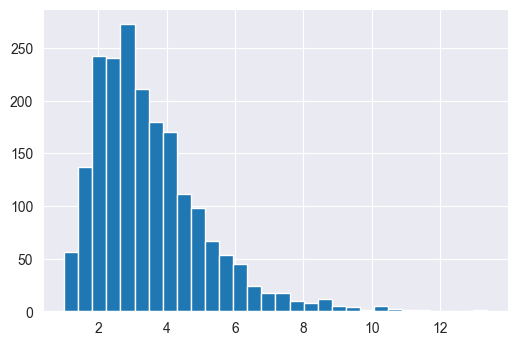

In [162]:
df_pool_size6['combine_rate'].hist(bins=30)

In [189]:
# https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestIndPower.html#statsmodels.stats.power.TTestIndPower
from statsmodels.stats.power import TTestIndPower
# TTestIndPower().plot_power(dep_var='nobs', nobs=500, effect_size=[0.1/1,5, 0.2/1,5, 0.3/1,5], alpha=0.5)
TTestIndPower().solve_power(effect_size=0.3/1.5, nobs1=None, alpha=0.05, power=0.8, ratio=1, alternative='two-sided')




393.40569899903375

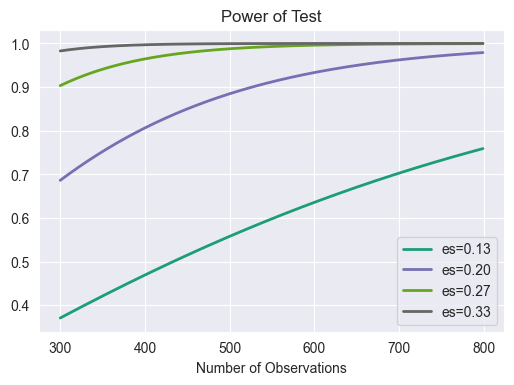

In [197]:
effect_sizes = np.array([0.2/1.5, 0.3/1.5, 0.4/1.5, 0.5/1.5])
sample_sizes = np.array(range(300, 800))
# calculate power curves from multiple power analyses
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes, alpha=0.05)
plt.show()

In [190]:
# https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.power_proportions_2indep.html#statsmodels.stats.proportion.power_proportions_2indep
from statsmodels.stats.proportion import samplesize_proportions_2indep_onetail
samplesize_proportions_2indep_onetail(\
                diff=0.04, prop2=0.9, power=0.8, ratio=1, alpha=0.05, value=0, alternative='two-sided')

720.9168750845892

# Worst senario analysis (seed 22)
https://console.treasuredata.com/app/queries/editor?queryId=2399901


# Count states and cities. Roadblocks: name not cleaned

In [70]:
df_mtxn.shape
df_mtxn = pd.merge(df_mtxn, df_pool[['geohash', 'show']].drop_duplicates(), how='left', on='geohash')

In [109]:
import re

input_str = "AAA? BBB. CCC! DDD.EEE"
output_str = re.sub('[^A-Za-z0-9]+', ' ', input_str)
output_str

'AAA BBB CCC DDD EEE'

In [110]:
import unidecode
df_mtxn['state_decode'] = df_mtxn['state'].apply(\
                        lambda x: unidecode.unidecode(x.lower()) if type(x)==str else x)
df_mtxn['city_decode'] = df_mtxn['city'].apply(\
        lambda x: re.sub('[^A-Za-z0-9]+', '', unidecode.unidecode(x.lower())) if type(x)==str else x)

In [115]:
df_mtxn[df_mtxn['show'].notna()]['state_decode'].nunique(), df_mtxn[df_mtxn['show'].notna()]['city_decode'].nunique()

(49, 383)

In [107]:
df_mtxn[df_mtxn['show'].notna()]['store_id'].nunique(), df_mtxn[df_mtxn['show'].notna()]['store_id'].nunique()/998

(2707, 2.712424849699399)

In [157]:
df_mtxn.groupby(['city_decode'])['geohash'].nunique().head()#.sort_values(ascending=False)

city_decode
07630                                            1
20denoviembrefranciscoimadero24190cddelcarmen    1
54060tlalnepantladebazmex                        1
abasolo                                          1
acambaro                                         5
Name: geohash, dtype: int64

In [71]:
print('number of states:', df_mtxn[df_mtxn['show']==1]['state'].nunique())
print('number of cities:', df_mtxn[df_mtxn['show']==1]['city'].nunique())
df_mtxn[df_mtxn['show']==1].groupby(['state'])['geohash'].nunique()

number of states: 51
number of cities: 287


state
AGUASCALIENTES                 1
Acambay                        1
Aguascalientes                 7
Baja California Sur            2
CDMX                          73
Cdmx                           1
Chalco de Díaz Covarrubias     1
Chiapas                       20
Chiapas Tuxtla Gutiérrez       1
Chihuahua                     20
Ciudad de Mexico               2
Ciudad de México              20
Coahuila                      17
Coahuila de Zaragoza           2
Colima                         4
Distrito Federal              41
Durango                        2
Estado de México              10
Guanajuato                     6
Guerrero                       8
Hidalgo                       14
Iztapalapa                     1
JALISCO                        1
Jalisco                       66
Mexico                         1
Mexkco                         1
Michoacan                      1
Michoacán                     39
Morelos                       10
Méx.                           2
Méxi